In [58]:
#importing libraries

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

amazon_train = pd.read_csv("amazon_train.csv")           #reading file
amazon_test = pd.read_csv("amazon_test.csv")             #reading file

amazon_train.isnull().values.any()                       #null values
amazon_test.isnull().values.any()                        #null values

amazon_train.head()                                      #printing first 5 rows

,review,sentiment
0,Love my Echo!,1
1,Loved it!,1
2,"Sometimes while playing a game, you can answer...",1
3,I have had a lot of fun with this thing. My 4 ...,1
4,Music,1


In [59]:
amazon_train["review"][159]                              #printing the 160th row

'Versatile and fun !!!'

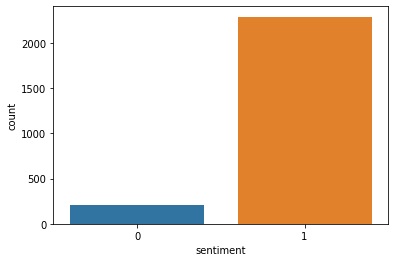

In [60]:
import seaborn as sns

sns.countplot(x='sentiment', data=amazon_train)          #seeing data distribution for train

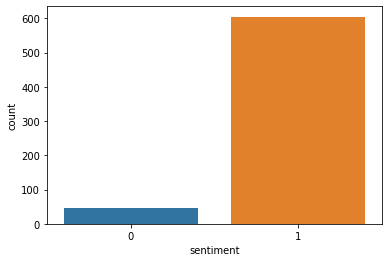

In [61]:
import seaborn as sns

sns.countplot(x='sentiment', data=amazon_test)          #seeing data distribution for test

In [62]:
#data preprocessing or 'cleaing up'

def preprocess_text(sen):
    #removing html tags
    sentence = remove_tags(sen)

    #remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    #removing single character
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    #removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence                                        #returning string to the calling function

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)                            #removing HTML <> tags

#preprocessing reviews and storing them in a new list for train and test
X=[]
X_train = amazon_train['review']
sentences = list(amazon_train['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

X_test = amazon_test['review']
sentences = list(amazon_test['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

#storing training and testing sentiment in respective columns
y_train = amazon_train['sentiment']
y_test = amazon_test['sentiment']

print(y_train.shape)                                       #printing number of rows in y

(2500,)


In [63]:
X[159]                                                     #printing 160th review after preprocessing/clean up

'Versatile and fun '

In [64]:
#creating a word-to-index dictionary

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)              #transforms words into a sequence of integers or a 'key'

In [65]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

#each sentence transforms into a 'list' with a maximum value length as 100 (adding 0's to empty spaces and truncating longer sequences)
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)   

In [66]:
from numpy import array
from numpy import asarray
from numpy import zeros

#loading GloVe word embeddings and creating a dicttionary with words as keys
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [67]:
#creating a weight matrix for the words in the training reviews
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [68]:
from keras.layers.recurrent import LSTM

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False) #false since not using my own embeddings
model.add(embedding_layer)

model.add(Flatten()) #flatten input tensor
model.add(Dense(1, activation='sigmoid'))

In [69]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary()) #printing summary of model

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 100)          405300    
_________________________________________________________________
flatten_8 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 10001     
Total params: 415,301
Trainable params: 10,001
Non-trainable params: 405,300
_________________________________________________________________
None


In [70]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2) #training model with training data

Train on 2000 samples, validate on 500 samples
Epoch 1/5
2000/2000 [==============================] - 0s 202us/step - loss: 0.4598 - acc: 0.8845 - val_loss: 0.3792 - val_acc: 0.9120
Epoch 2/5
2000/2000 [==============================] - 0s 15us/step - loss: 0.2961 - acc: 0.9110 - val_loss: 0.3424 - val_acc: 0.9120
Epoch 3/5
2000/2000 [==============================] - 0s 15us/step - loss: 0.2355 - acc: 0.9310 - val_loss: 0.3009 - val_acc: 0.9120
Epoch 4/5
2000/2000 [==============================] - 0s 15us/step - loss: 0.2043 - acc: 0.9350 - val_loss: 0.2814 - val_acc: 0.9120
Epoch 5/5
2000/2000 [==============================] - 0s 15us/step - loss: 0.1816 - acc: 0.9375 - val_loss: 0.2810 - val_acc: 0.9120


In [71]:
score = model.evaluate(X_test, y_test, verbose=1) #to evaluate performance of the model, using the test data

650/650 [==============================] - 0s 20us/step


In [72]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.26367841243743895
Test Accuracy: 0.9307692050933838


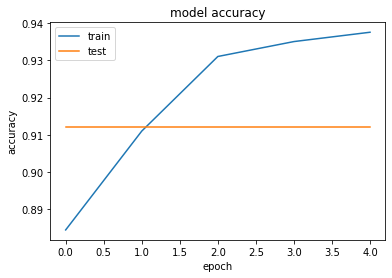

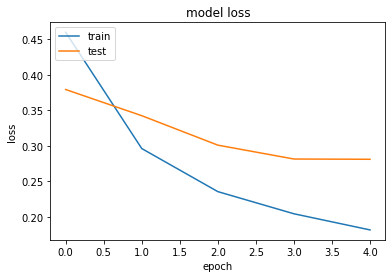

In [73]:
#plotting loss and accuracy scores
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss') #bigger the number, more deviation from the actual data and the predicted values/tested data
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()